# Analyzing scaling with mass 
Nov 24, 2021 \
Venkitesh Ayyar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

In [2]:
%matplotlib widget

In [3]:
from ipywidgets import *
from scipy import fftpack
from matplotlib.colors import LogNorm, PowerNorm, Normalize

In [4]:
# # Load data

def f_get_data(fname): # Modified for complex field
    
    def f_conv_complex(strg):
        ''' Convert input from a+ib to python complex form'''
        arr=[np.float64(k) for k in strg.split('+i')]
        return complex(arr[0],arr[1])
    
    arr=np.loadtxt(fname,delimiter=',',dtype=str)
    
    arr_iters=arr[:,0].astype(int) # First element is iteration number
    
    arr1=np.vectorize(f_conv_complex)(arr[:,1:-1]) # Skip last element (null string) and first (iteration)
    del(arr)
    # print(arr1.shape)
    L=int(np.sqrt(arr1.shape[1])) # Get lattice size
    num=arr1.shape[0]
    print(L)
    # a3=arr1.reshape(134,L,L) :  simple reshape doesn't do it in the correct order
    ## Reshape to 2D image
    arr2=np.empty((num,L,L),dtype=complex)
    for i in range(num): 
        for x in range(L):
            for y in range(L):
                arr2[i,x,y]=arr1[i,x+y*L]

    print(arr2.shape)
    
    return arr2

def f_rescale(arr,mean):
    a1=np.array([abs(i-mean) for i in arr])
    a1=np.abs(a1)
    return a1

# _=f_get_data(fname)
# f_rescale(arr_lst[0][:5],soln)

In [5]:
def f_spectrum(arr):
    F2 = np.fft.fft2(arr)
    F2=np.fft.fftshift(F2,axes=None)
    ### Absolute value of F-transform
    F2 = np.abs(F2)**2
    
    return F2 

def f_batch_spectrum(arr):
    P_k=[f_spectrum(i) for i in arr]
    return np.array(P_k)


In [6]:
# fname='../results_phi.txt'
# fname='../results_residue.txt'
# a1=f_get_data(fname)

### Read data

In [20]:
arr_type='phi'
m=-0.05
L=32
blk=2
ndof=2
# arr_type='residue'
lst=[str(i) for i in range(0,5)]
# lst=[str(i) for i in [0,2,4]]

lst2=['results_{0}_L{1}_m{2}_lvls{3}_blk{4}_ndof{5}.txt'.format(arr_type,L,m,i,blk,ndof) for i in lst]

num=len(lst2)
arr_lst=[]
fldr='results_files/'
for i in range(num):     
    fname='../3_complex_scalar_adaptivemgrid/1_regular_tl_code/stored_results/beta_6.0_ndof2/'+lst2[i]
    print(fname)
    arr_lst.append(f_get_data(fname))


In [21]:
# arr_type='phi'
m=-0.06
L=128
blk=4
ndof=2
arr_type='residue'
arr_lst=[]

fname='../4_non-telescoping_mg/1_nontl_avg_copies/results_residue.txt'    
arr_lst.append(f_get_data(fname))

128
(124, 128, 128)


In [35]:
# labels_lst=['tl_2lvl','ntl_1copy','ntl_2copy','ntl_3copy','ntl_4copy','tl_3lvl']
# labels_lst=['a','b','c','d','e']
# labels_lst=['0lvl','1lvl','2lvl','3lvl','4lvl']
# labels_lst=['0lvl','2lvl','4lvl']

In [25]:
arr_lst[0].shape

(124, 128, 128)

In [26]:
## Pick best solution
soln=arr_lst[0][-1] 

# Convert phi to error
err_lst=[]
for i,arr in enumerate(arr_lst):
    print(i,arr.shape)
    err_lst.append(f_rescale(arr_lst[i],soln))


0 (124, 128, 128)


In [11]:
## Compute spectrum
aspec_lst=[f_batch_spectrum(arr)[:] for arr in err_lst]

In [38]:
type(arr_lst[0][0,0,0])
err_lst[0].dtype

dtype('float64')

In [12]:
err_lst[0][-1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Debug single run

#### Convergence of spectral values

In [13]:
def f_plot_spec_iteration(arr,kx,ky):
    L=arr.shape[-1]
    id_x,id_y=kx+L//2,ky+L//2
    # print(arr[1:,id_x,id_y])
    plt.figure()
    plt.plot(arr[1:,id_x,id_y]/np.max(arr[1:,id_x,id_y]),marker='o',linestyle='')
    plt.xlabel('Iteration')
    plt.yscale('log')
    plt.show()
# f_plot_spec_iteration(aspec_lst[0],0,0)

kmax=aspec_lst[0].shape[1]//2
interact(f_plot_spec_iteration,arr=fixed(aspec_lst[0]),kx=IntSlider(min=-kmax,max=kmax-1,step=1),ky=IntSlider(min=-kmax,max=kmax-1,step=1))


interactive(children=(IntSlider(value=0, description='kx', max=63, min=-64), IntSlider(value=0, description='k…

<function __main__.f_plot_spec_iteration(arr, kx, ky)>

error = (phi - solution) \
FFT of $ error[x,y] \rightarrow error[kx,ky] $ \
Plotting : $$ \frac{\mbox{error}[iter, kx, ky]}{max(\mbox{error}[iter,kx,ky])} $$ 

(124, 128, 128)


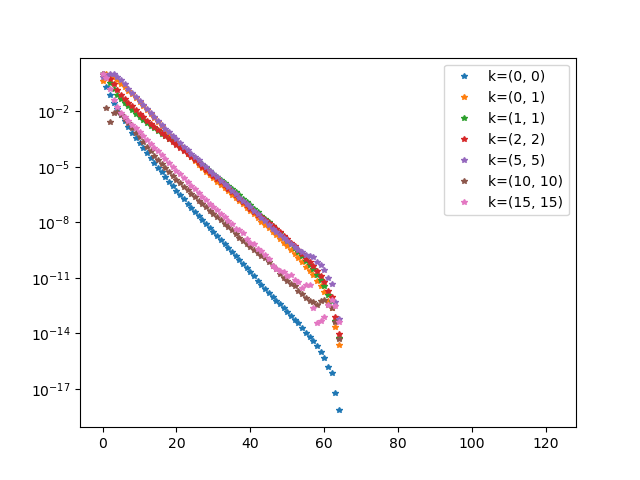

In [14]:
def f_grid_iter_plot(arr,klist):
    
    fig=plt.figure()

    size=len(klist)
    cols=max(size//2,1)
    cols=min(cols,4)
    rows=int(np.ceil(size/cols))
    # rows,cols=2,2
    
    L=arr.shape[-1]
    print(arr.shape)
    # arr=arr[:]/np.max(arr)
    for count,k in enumerate(klist):
        kx,ky=k[0],k[1]
        id_x,id_y=kx+L//2,ky+L//2
        # fig.add_subplot(rows,cols,count+1)
        # plt.plot(arr[1:,id_x,id_y], marker='*',markersize=4,linestyle='',label="k="+str(k))
        plt.plot(arr[1:,id_x,id_y]/np.max(arr[1:,id_x,id_y]), marker='*',markersize=4,linestyle='',label="k="+str(k))
        plt.legend()
        plt.yscale('log')
    plt.show()

klist=[(0,0),(0,1),(1,1),(2,2),(5,5),(10,10),(15,15)]
f_grid_iter_plot(aspec_lst[0][:5000],klist)


Slopes: 

0 : (1-0.56)/600 : 0.0008
1 : (1-5e-6)/600 : 0.002
2 : (1-3e-4)/200 : 0.005
3 : (1-1e-5)/75 :  0.013
4 : (1-6e-6)/10  : 0.1

### Compare different runs

In [15]:
# Plot mean absolute error
def f_plot_mean_err(arrlist,labellist):
    fig=plt.figure()
        
    mrkrs=['o','*','v','x','D','H','s','8','p']
    for count,(lbl,mrkr) in enumerate(zip(labellist,mrkrs)):
        arr=arrlist[count]
        ans=np.mean(arr,axis=(1,2))
        plt.plot(ans, marker=mrkr,markersize=5,linestyle='',label=lbl)
        
        plt.legend()
    plt.yscale('log')
    plt.title('Mean of error')
    plt.xlabel('Iterations on top level / 3')
    plt.show()

f_plot_mean_err(err_lst[:5],labels_lst[:5])

NameError: name 'labels_lst' is not defined

In [16]:
# Plot Spectral coefficients
def f_compare_runs(arrlist,labellist,kx,ky):
    fig=plt.figure()

    size=len(labellist)
    cols=max(size//2,1)
    cols=min(cols,4)
    rows=int(np.ceil(size/cols))
    # rows,cols=2,2
    
    L=arr.shape[-1]
    id_x,id_y=kx+L//2,ky+L//2
        
    mrkrs=['o','*','v','x','D','H','s','8','p']
    for count,(lbl,mrkr) in enumerate(zip(labellist,mrkrs)):
        a_spec=arrlist[count]
        # fig.add_subplot(rows,cols,count+1)
        plt.plot(a_spec[1:,id_x,id_y], marker=mrkr,markersize=5,linestyle='',label=lbl)

        plt.legend()
    plt.yscale('log')
    plt.title('Fourier coefficient of Error for kx=%s, ky=%s'%(kx,ky))
    plt.xlabel('Iterations on top level / 3')
    plt.show()
    
# f_compare_runs(aspec_lst[:],labels_lst[:],2,0)

In [44]:
kmax=arr_lst[0].shape[-1]//2

interact(f_compare_runs,arrlist=fixed(aspec_lst[:5]),labellist=fixed(labels_lst[:5]),kx=IntSlider(min=-kmax,max=kmax-1,step=1),ky=IntSlider(min=-kmax,max=kmax-1,step=1))


interactive(children=(IntSlider(value=0, description='kx', max=15, min=-16), IntSlider(value=0, description='k…

<function __main__.f_compare_runs(arrlist, labellist, kx, ky)>

## Plot convergence speed

In [17]:
labels_lst
max_itrs_lst=[i.shape[0] for i in err_lst]

plt.figure(figsize=(8,5))
plt.plot(labels_lst,max_itrs_lst,marker='*',linestyle='')
plt.ylabel("Iterations per leve")
plt.xlabel("Run type")

NameError: name 'labels_lst' is not defined

In [46]:
# for i in range(err_lst[1].shape[0])[:5]:
#     if not np.allclose(err_lst[1][i],err_lst[2][i]):
#         for x in range(L):
#             for y in range(L):
#                 if ((err_lst[1][i][x,y]-err_lst[2][i][x,y])> 1e-10):
#                     print(err_lst[1][i][x,y]-err_lst[2][i][x,y])
